# Example of map layout

This example uses the approach described in 

http://grindgis.com/blog/checklist-map-design-layout

### Notebook magic commands

In [6]:
%matplotlib inline

### Notebook imports

In [7]:
# all imports should go here

import pandas as pd
import sys
import os
import subprocess
import datetime
import platform
import datetime
import math

import matplotlib.pyplot as plt
#import seaborn as sb

import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.io.img_tiles import StamenTerrain
from cartopy.io.img_tiles import GoogleTiles
from owslib.wmts import WebMapTileService

from matplotlib.path import Path
import matplotlib.patheffects as PathEffects
from matplotlib import patheffects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import numpy as np

### Notebook version status

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [10]:
# show info to support reproducability

def python_env_name():
    envs = subprocess.check_output('conda env list').splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(filter(lambda s: '*' in str(s), envu))[0]
    env_name = str(active_env).split()[0]
    return env_name
#end python_env_name

print('python version : ' + sys.version)
print('python environment :', python_env_name())
print('pandas version : ' + pd.__version__)

print('current wkg dir: ' + os.getcwd())
print('Notebook name: ' + theNotebook)
print('Notebook run at: ' + str(datetime.datetime.now())+ ' local time')
print('Notebook run at: ' + str(datetime.datetime.utcnow()) + ' UTC') 
print('Notebook run on: ' + platform.platform())


python version : 3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
python environment : root
pandas version : 0.18.1
current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\CartopyNotebookProject\develop
Notebook name: MapLayoutExample
Notebook run at: 2017-02-18 19:43:36.599872 local time
Notebook run at: 2017-02-18 09:43:36.599872 UTC
Notebook run on: Windows-10-10.0.14393-SP0


## Define some constants for 1:10m drawing

In [11]:
BORDERS_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              '10m', edgecolor='black', facecolor='none')
#"""country boundaries."""


BORDERS2_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces',
                              '10m', edgecolor='black', facecolor='none')
#"""country boundaries."""

COASTLINE_10m = cartopy.feature.NaturalEarthFeature('physical', 'coastline', '10m',
                                edgecolor='black', facecolor='none')
#"""coastline, including major islands."""


LAKES_10m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                            edgecolor='face',
                            facecolor=cartopy.feature.COLORS['water'])
#""" natural and artificial lakes."""


LAND_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                           edgecolor='face',
                           facecolor=cartopy.feature.COLORS['land'])
#"""land polygons, including major islands."""


OCEAN_10m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
                            edgecolor='face',
                            facecolor=cartopy.feature.COLORS['water'])
#"""Small scale (1:110m) ocean polygons."""


RIVERS_10m = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                             edgecolor=cartopy.feature.COLORS['water'],
                             facecolor='none')
#"""single-line drainages, including lake centerlines."""


### Set up figure with multiple axes

ax holds the main map, 

ax2 the 'locating map'

ax3 the surrounding frame

ax4 the North Symbol (to be rotated as needed, here shown as North=Up)

ax5 contains the Legend

ax6 contains the Title

### helper functions

In [12]:
def to_radians(theta):
    return np.divide(np.dot(theta, np.pi), np.float32(180.0))
#end to_radians

def to_degrees(theta):
    return np.divide(np.dot(theta, np.float32(180.0)), np.pi)
#end to_degrees


def displace(lat, lng, theta, distance):
    """
    Displace a LatLng theta degrees counterclockwise and some
    meters in that direction.
    Notes:
        http://www.movable-type.co.uk/scripts/latlong.html
        0 DEGREES IS THE VERTICAL Y AXIS! IMPORTANT!
    Args:
        theta:    A number in degrees.
        distance: A number in meters.
    Returns:
        A new LatLng.
    """
    
    E_RADIUS = 6378137.0 
    theta = np.float32(theta)

    delta = np.divide(np.float32(distance), np.float32(E_RADIUS))


    theta = to_radians(theta)
    lat1 = to_radians(lat)
    lng1 = to_radians(lng)

    lat2 = np.arcsin( np.sin(lat1) * np.cos(delta) +
                      np.cos(lat1) * np.sin(delta) * np.cos(theta) )

    lng2 = lng1 + np.arctan2( np.sin(theta) * np.sin(delta) * np.cos(lat1),
                              np.cos(delta) - np.sin(lat1) * np.sin(lat2))

    lng2 = (lng2 + 3 * np.pi) % (2 * np.pi) - np.pi

    return (to_degrees(lat2), to_degrees(lng2))
#end displace

Function to stop extraneous clutter (labels, tick marks, etc)

In [13]:
def blank_axes(ax):
    """
    blank_axes:  blank the extraneous spines and tick marks for an axes
    
    Input:
    ax:  a matplotlib Axes object
    
    Output: None
    """
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.tick_params(labelbottom='off', labeltop='off', labelleft='off', labelright='off' ,\
                    bottom='off', top='off', left='off', right='off' )
#end blank_axes

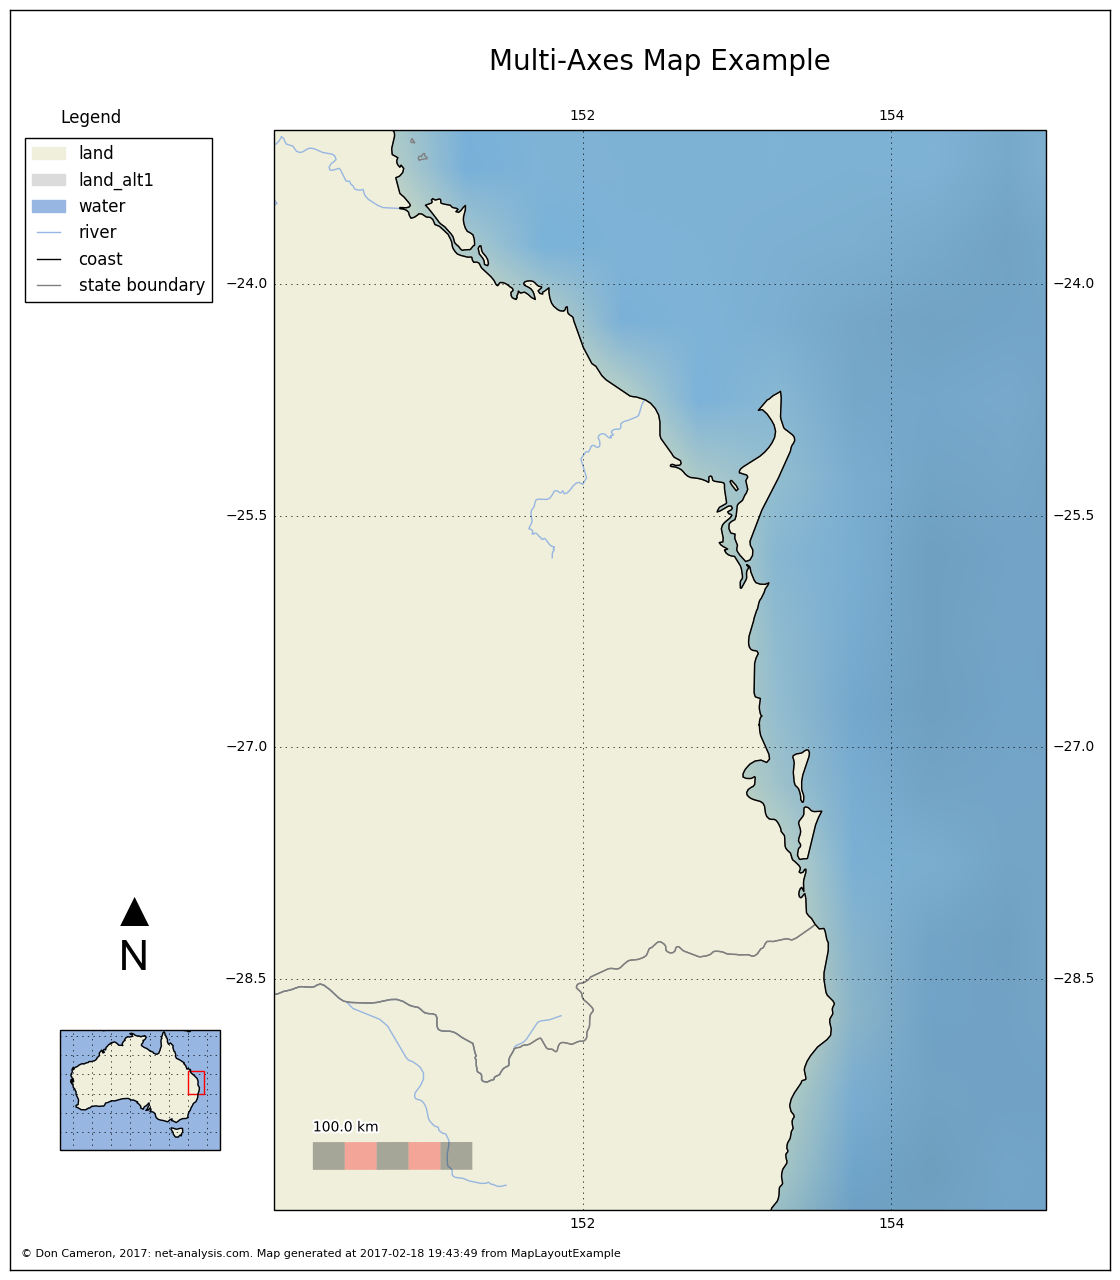

In [14]:
fig = plt.figure(figsize=(10,12))

# ------------------------------- Surrounding frame ------------------------------
# set up frame full height, full width of figure, this must be called first

left = -0.05
bottom = -0.05
width = 1.1
height = 1.05
rect = [left,bottom,width,height]
ax3 = plt.axes(rect)

# turn on the spines we want, ie just the surrounding frame
blank_axes(ax3)
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)

ax3.text(0.01,0.01,'© Don Cameron, 2017: net-analysis.com. '+
         'Map generated at '+datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + ' from ' +theNotebook, fontsize=8)

# ---------------------------------  Main Map -------------------------------------
#
# set up main map almost full height (allow room for title), right 80% of figure

left = 0.2
bottom = 0
width = 0.8
height = 0.90
rect = [left,bottom,width,height]

ax = plt.axes(rect, projection=ccrs.PlateCarree(), )
ax.set_extent((150, 155, -30, -23))


ax.coastlines(resolution='10m', zorder=2)

#land polygons, including major islands, use cartopy default color
ax.add_feature(LAND_10m)
ax.add_feature(RIVERS_10m)
ax.add_feature(BORDERS2_10m, edgecolor='grey')
ax.stock_img()
# stock image is good enough for example, but OCEAN_10m could be used, but very slow
#ax.add_feature(OCEAN_10m)



ax.gridlines(draw_labels=True, xlocs=[150, 152, 154, 155])

lon0, lon1, lat0, lat1 = ax.get_extent()

# bar offset is how far from bottom left corner scale bar is (x,y) and how far up is scale bar text
bar_offset = [0.05, 0.05, 0.07]
bar_lon0 = lon0 + (lon1-lon0)*bar_offset[0]
bar_lat0 = lat0 + (lat1-lat0)*bar_offset[1]

text_lon0 = bar_lon0
text_lat0 = lat0 + (lat1-lat0)*bar_offset[2]
bar_tickmark = 20000 # metres
bar_ticks = 5
bar_alpha = 0.3

bar_color = ['black', 'red']

# draw a scale bar that is a set of colored line segments (bar_ticks of these), bar_tickmarks long
for i in range(bar_ticks):
     #  90 degrees = direction of horizontal scale bar
    end_lat, end_lon = displace(bar_lat0, bar_lon0, 90, bar_tickmark)
    # capstyle must be set so line segments end square
    #TODO make transform match ax projection
    ax.plot([bar_lon0, end_lon], [bar_lat0, end_lat], color=bar_color[i%2], linewidth=20, 
            transform=ccrs.PlateCarree(), solid_capstyle='butt', alpha = bar_alpha)
    # start of next bar is end of last bar
    bar_lon0 = end_lon
    bar_lat0 = end_lat
#end for

# highlight text with white background
buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
# Plot the scalebar label
units = 'km'
#TODO make transform match ax projection
t0 = ax.text(text_lon0, text_lat0, str(bar_ticks*bar_tickmark/1000) + ' ' + units, transform=ccrs.PlateCarree(),
    horizontalalignment='left', verticalalignment='bottom',
    path_effects=buffer, zorder=2)
               


# ---------------------------------Locating Map ------------------------
#
# set up index map 20% height, left 16% of figure
left = 0
bottom = 0
width = 0.16
height = 0.2
rect = [left,bottom,width,height]


ax2 = plt.axes(rect, projection=ccrs.PlateCarree(), )
ax2.set_extent((110,160, -45, -10))
#  ax2.set_global()  will show the whole world as context

ax2.coastlines(resolution='110m', zorder=2)
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)

ax2.gridlines()


lon0,lon1,lat0,lat1 = ax.get_extent()
box_x = [lon0, lon1, lon1, lon0, lon0]
box_y = [lat0, lat0, lat1, lat1, lat0]

plt.plot(box_x, box_y, color='red',  transform=ccrs.Geodetic())


# -------------------------------- Title -----------------------------
# set up map title top 4% of figure, right 80% of figure

left = 0.2
bottom = 0.95
width = 0.8
height = 0.04
rect = [left,bottom,width,height]
ax6 = plt.axes(rect)
ax6.text(0.5, 0.0,'Multi-Axes Map Example', ha='center', fontsize=20)
blank_axes(ax6)
# ---------------------------------North Arrow  ----------------------------
#
left = 0
bottom = 0.2
width = 0.16
height = 0.2
rect = [left,bottom,width,height]
rect = [left,bottom,width,height]
ax4 = plt.axes(rect)

# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax4.text(0.5, 0.0,u'\u25B2 \nN ', ha='center', fontsize=30, family='Arial', rotation = 0)
blank_axes(ax4)
# ------------------------------------  Legend -------------------------------------

# legends can be quite long, so set near top of map (0.4 - bottom + 0.5 height = 0.9 - near top)
left = 0
bottom = 0.4
width = 0.16
height = 0.5
rect = [left,bottom,width,height]
rect = [left,bottom,width,height]
ax5 = plt.axes(rect)
blank_axes(ax5)



# create an array of color patches and associated names for drawing in a legend
# colors are the predefined colors for cartopy features (only for example, Cartopy names are unusual)
colors = sorted(cartopy.feature.COLORS.keys())

# handles is a list of patch handles
handles = []
# names is the list of corresponding labels to appear in the legend
names = []

# for each cartopy defined color, draw a patch, append handle to list, and append color name to names list
for c in colors:
    patch = mpatches.Patch(color=cfeature.COLORS[c], label=c)
    handles.append(patch)
    names.append(c)
#end for

# do some example lines with colors
river = mlines.Line2D([], [], color=cfeature.COLORS['water'], marker='',
                          markersize=15, label='river')
coast = mlines.Line2D([], [], color='black', marker='',
                          markersize=15, label='coast')
bdy  = mlines.Line2D([], [], color='grey', marker='',
                          markersize=15, label='state boundary')
handles.append(river)
handles.append(coast)
handles.append(bdy)
names.append('river')
names.append('coast')
names.append('state boundary')
                     
            

# create legend
ax5.legend(handles, names)
ax5.set_title('Legend',loc='left')

plt.show()


## Figure the various axes in the figure

Note some will expand to fit content

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.Orthographic(central_longitude=140, central_latitude=-30))

ax.set_global()
ax.gridlines()

ax.coastlines()
ax.add_feature(cfeature.LAND)

plt.plot([110, 154, 154,  110, 110], [-40, -40, -10, -10, -40], color='red',  transform=ccrs.Geodetic())
plt.plot([110, 154, 154,  110, 110], [-40, -40, -10, -10, -40], color='blue', transform=ccrs.Orthographic())

plt.show()

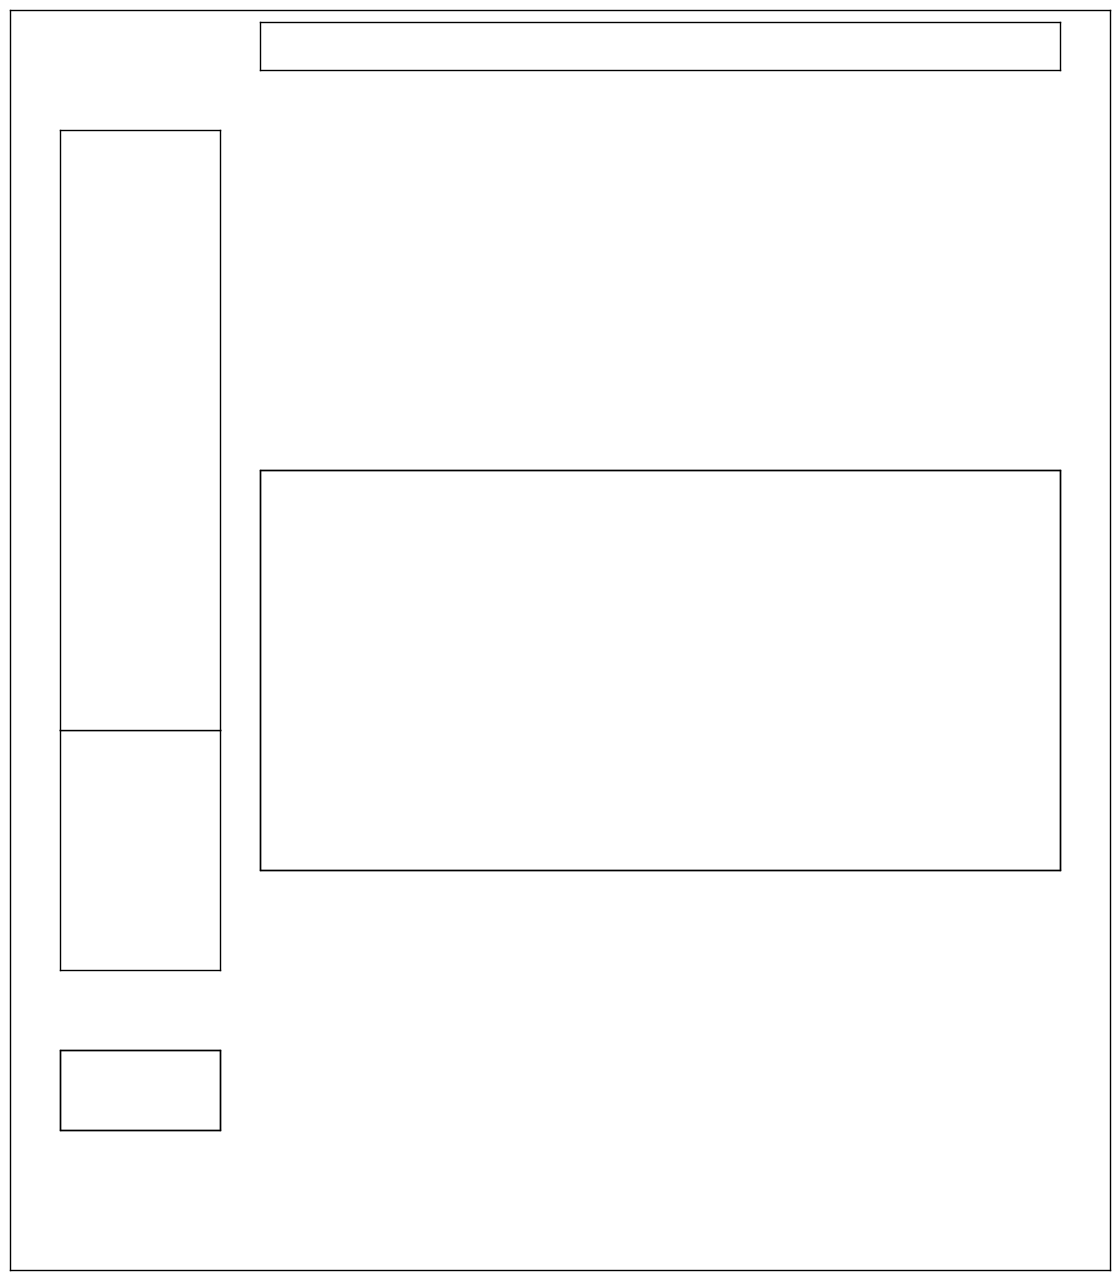

In [16]:
fig = plt.figure(figsize=(10,12))

# ------------------------------- Surrounding frame ------------------------------
# set up frame full height, full width of figure, this must be called first

left = -0.05
bottom = -0.05
width = 1.1
height = 1.05
rect = [left,bottom,width,height]
ax3 = plt.axes(rect)

# turn on the spines we want, ie just the surrounding frame
blank_axes(ax3)
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)


# ---------------------------------  Main Map -------------------------------------
#
# set up main map almost full height (allow room for title), right 80% of figure

left = 0.2
bottom = 0
width = 0.8
height = 0.90
rect = [left,bottom,width,height]

ax = plt.axes(rect, projection=ccrs.PlateCarree(), )
# turn on the spines we want, ie just the surrounding frame
blank_axes(ax)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# ---------------------------------Locating Map ----------------------------
#
# set up index map 20% height, left 16% of figure
left = 0
bottom = 0
width = 0.16
height = 0.2
rect = [left,bottom,width,height]


ax2 = plt.axes(rect, projection=ccrs.PlateCarree(), )
# turn on the spines we want, ie just the surrounding frame
blank_axes(ax2)
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)


# -------------------------------- Title ---------------------------------
# set up map title top 4% of figure, right 80% of figure

left = 0.2
bottom = 0.95
width = 0.8
height = 0.04
rect = [left,bottom,width,height]
ax6 = plt.axes(rect)
# turn on the spines we want, ie just the surrounding frame
blank_axes(ax6)
ax6.spines['right'].set_visible(True)
ax6.spines['top'].set_visible(True)
ax6.spines['bottom'].set_visible(True)
ax6.spines['left'].set_visible(True)
# ---------------------------------North Arrow  ----------------------------
#
left = 0
bottom = 0.2
width = 0.16
height = 0.2
rect = [left,bottom,width,height]
rect = [left,bottom,width,height]
ax4 = plt.axes(rect)

# turn on the spines we want, ie just the surrounding frame
blank_axes(ax4)
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.spines['bottom'].set_visible(True)
ax4.spines['left'].set_visible(True)
# ------------------------------------  Legend -------------------------------------

# legends can be quite long, so set near top of map (0.4 - bottom + 0.5 height = 0.9 - near top)
left = 0
bottom = 0.4
width = 0.16
height = 0.5
rect = [left,bottom,width,height]
rect = [left,bottom,width,height]
ax5 = plt.axes(rect)

# turn on the spines we want, ie just the surrounding frame
blank_axes(ax5)
ax5.spines['right'].set_visible(True)
ax5.spines['top'].set_visible(True)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(True)

plt.show()


MapLayoutExample
